In [1]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1) We'll reuse the segmentation-based code from your snippet:
def segment_and_label(frame_bgr, threshold=50, min_area=5):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    num_labels, labels = cv2.connectedComponents(bin_img)
    for label_id in range(1, num_labels):
        area = np.sum(labels == label_id)
        if area < min_area:
            labels[labels == label_id] = 0
    return labels

def count_nuclei(frame_bgr, threshold=50, min_area=5):
    """
    Returns the number of connected components > 0 (i.e. nuclei).
    """
    labels = segment_and_label(frame_bgr, threshold=threshold, min_area=min_area)
    nucleus_ids = np.unique(labels)
    nucleus_ids = nucleus_ids[nucleus_ids > 0]
    return len(nucleus_ids)

def compute_prolif_ratio(video_path, threshold=50, min_area=5):
    """
    Reads first & last frame of the video, returns (ratio, first_count, last_count).
    ratio = (last_count / first_count) or 0 if first_count=0.
    """
    cap = cv2.VideoCapture(str(video_path))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count < 2:
        cap.release()
        return 0.0, 0, 0

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, first_frame = cap.read()
    if not ret:
        cap.release()
        return 0.0, 0, 0
    first_count = count_nuclei(first_frame, threshold=threshold, min_area=min_area)

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count - 1)
    ret, last_frame = cap.read()
    if not ret:
        cap.release()
        return 0.0, first_count, 0
    last_count = count_nuclei(last_frame, threshold=threshold, min_area=min_area)

    cap.release()

    ratio = (last_count / first_count) if first_count > 0 else 0.0
    return ratio, first_count, last_count

# 2) Now let's set up the data loading logic in the notebook:

# a) Load the CSV into a dataframe
csv_path = "/proj/aicell/users/x_aleho/video-diffusion/data/processed/idr0013/idr0013-screenA-annotation.csv"
df = pd.read_csv(csv_path)

# The CSV presumably has columns like "Plate", "Well Number", "Plate_Well",
# plus "Score - increased proliferation (automatic)". Let's rename for convenience:
df.rename(columns={"Score - increased proliferation (automatic)": "prolif_auto"}, inplace=True)

# b) Build a (plate, wellNum) -> Plate_Well map:
plateWell_map = {}
for idx, row in df.iterrows():
    plate = row["Plate"]
    well_num = str(row["Well Number"])  # ensure string
    plateWell_map[(plate, well_num)] = row["Plate_Well"]

# c) We'll now walk the plate folders to find all mp4 files
data_root = Path("/proj/aicell/users/x_aleho/video-diffusion/data/processed/idr0013")
# e.g. directories: LT0001_02, LT0001_09, etc.
video_info_list = []

for plate_folder in data_root.iterdir():
    if not plate_folder.is_dir():
        continue

    # plate_folder might be "LT0001_02"
    # gather all .mp4
    for mp4file in plate_folder.glob("*.mp4"):
        # e.g. "00384_01.mp4"
        # parse out well_num from the filename
        match = re.match(r"^0*(\d+)_\d+\.mp4$", mp4file.name)
        if not match:
            continue
        well_num_str = match.group(1)  # e.g. "384"

        # see if we have Plate_Well
        plate_well = plateWell_map.get((plate_folder.name, well_num_str))
        if plate_well is not None:
            # We'll store a record for matching
            video_info_list.append({
                "plate_folder": plate_folder.name,
                "well_num": well_num_str,
                "Plate_Well": plate_well,
                "video_path": mp4file
            })

vid_df = pd.DataFrame(video_info_list)
print(f"Found {len(vid_df)} matched videos")

# d) Merge this vid_df with your original df on "Plate_Well" so we have auto-scores & video path in one place:
merged = pd.merge(df, vid_df, on="Plate_Well", how="inner")
print("After merging, shape:", merged.shape)

/tmp/ipykernel_2191827/884962319.py:63: DtypeWarning: Columns (10,25,33,35,36,37,38,39,40,41,44,45,48,49,62,63,65,81,82,83,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,114,115,116,117,118,119,120,121,122,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Found 1920 matched videos
After merging, shape: (1920, 146)


In [4]:
merged.head()

,Plate,Well Number,Well,Plate_Well,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,...,Phenotype 16 Term Accession,Phenotype 17,Phenotype 17 Term Name,Phenotype 17 Term Accession,Phenotype 18,Phenotype 18 Term Name,Phenotype 18 Term Accession,plate_folder,well_num,video_path
0,LT0001_02,1,A1,LT0001_02_A1,Homo sapiens,NCBITaxon,NCBITaxon_9606,HeLa,EFO,EFO_0001185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LT0001_02,1,/proj/aicell/users/x_aleho/video-diffusion/dat...
1,LT0001_02,2,A2,LT0001_02_A2,Homo sapiens,NCBITaxon,NCBITaxon_9606,HeLa,EFO,EFO_0001185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LT0001_02,2,/proj/aicell/users/x_aleho/video-diffusion/dat...
2,LT0001_02,3,A3,LT0001_02_A3,Homo sapiens,NCBITaxon,NCBITaxon_9606,HeLa,EFO,EFO_0001185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LT0001_02,3,/proj/aicell/users/x_aleho/video-diffusion/dat...
3,LT0001_02,4,A4,LT0001_02_A4,Homo sapiens,NCBITaxon,NCBITaxon_9606,HeLa,EFO,EFO_0001185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LT0001_02,4,/proj/aicell/users/x_aleho/video-diffusion/dat...
4,LT0001_02,5,A5,LT0001_02_A5,Homo sapiens,NCBITaxon,NCBITaxon_9606,HeLa,EFO,EFO_0001185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LT0001_02,5,/proj/aicell/users/x_aleho/video-diffusion/dat...


Correlation matrix:
                  prolif_auto  my_prolif_ratio
prolif_auto         1.000000         0.447886
my_prolif_ratio     0.447886         1.000000


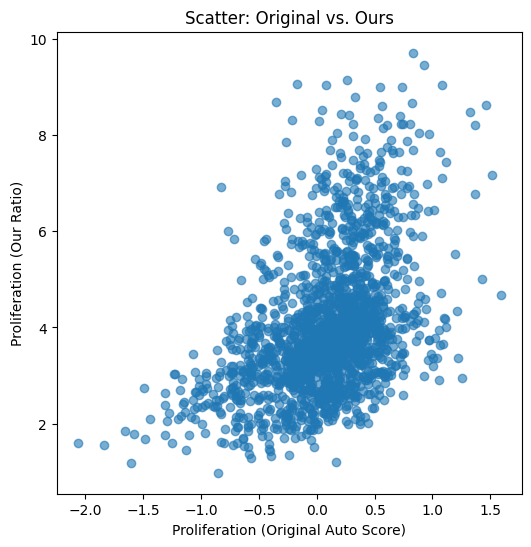

In [5]:
# e) Now let's compute the proliferation ratio for each row's video. 
# We'll store it in a new column "my_prolif_ratio"

my_ratios = []
for idx, row in merged.iterrows():
    vpath = row["video_path"]
    ratio, first_ct, last_ct = compute_prolif_ratio(vpath, threshold=50, min_area=5)
    my_ratios.append(ratio)

merged["my_prolif_ratio"] = my_ratios

# f) Inspect the merged dataframe
merged[["Plate_Well", "prolif_auto", "my_prolif_ratio", "video_path"]].head(10)

# 3) Let's do a quick correlation and scatter plot
corr_val = merged[["prolif_auto","my_prolif_ratio"]].corr(method="pearson")
print("Correlation matrix:\n", corr_val)

plt.figure(figsize=(6,6))
plt.scatter(merged["prolif_auto"], merged["my_prolif_ratio"], alpha=0.6)
plt.xlabel("Proliferation (Original Auto Score)")
plt.ylabel("Proliferation (Our Ratio)")
plt.title("Scatter: Original vs. Ours")
plt.show()